#### Set library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa import seasonal, stattools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as probplot # prob plot
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

#### Data
Data được lấy từ Kaggle.com, số liệu chứng khoán của mã AABA từ năm 2006

Mục tiêu:

EDA, dự báo

In [2]:
df = pd.read_csv(r"C:\Users\HIEN\Downloads\AABA_2006-01-01_to_2018-01-01.csv", index_col=['Date'], parse_dates=['Date'])

In [3]:
print(df.head())
df.info()

             Open   High    Low  Close    Volume  Name
Date                                                  
2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
Open      3019 non-null float64
High      3019 non-null float64
Low       3019 non-null float64
Close     3019 non-null float64
Volume    3019 non-null int64
Name      3019 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [4]:
# Lấy trung bình Giá mở cửa và đóng cửa
df['Mean'] =  (df['Open'] + df['Close'])/2
df.head(3)

,Open,High,Low,Close,Volume,Name,Mean
Date,,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA,40.300
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA,41.095
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA,41.230


Text(0.5, 1.0, 'Time series plot')

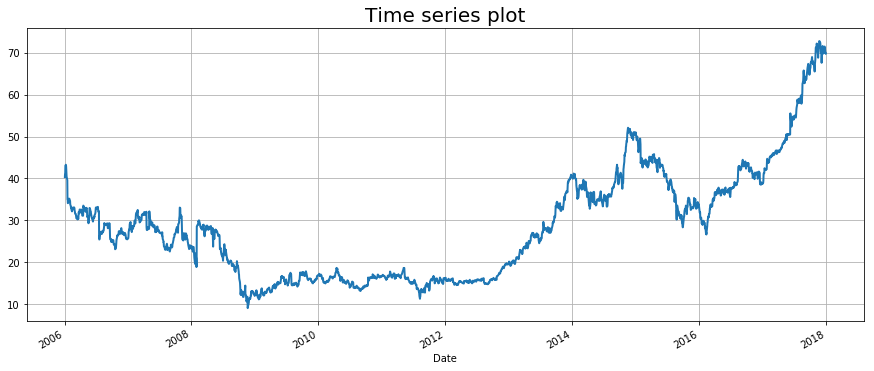

In [5]:
# Time series plot
df_ts = df['Mean'].plot(figsize=(15,6), grid=True, lw=2)
plt.title('Time series plot', fontsize=20)

In [6]:
def plot_tsa(df, lags):
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    sm.graphics.tsa.plot_acf(df, lags=lags, ax = ax[0,0])
    sm.graphics.tsa.plot_pacf(df, lags= lags, ax = ax[0,1])
    
    sm.qqplot(df, line='s', ax=ax[1,0])
    ax[1,0].set_title('QQ Plot')
    probplot.probplot(df, plot=ax[1,1])
    
    #plt.tight_layout()
    return

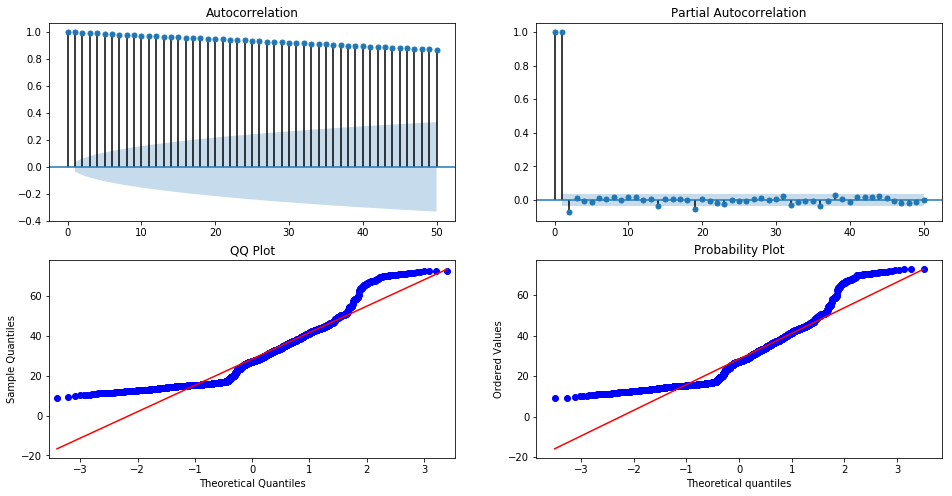

In [7]:
plot_tsa(df['Mean'], 50)

Text(0.5, 1.0, 'QQ Plot')

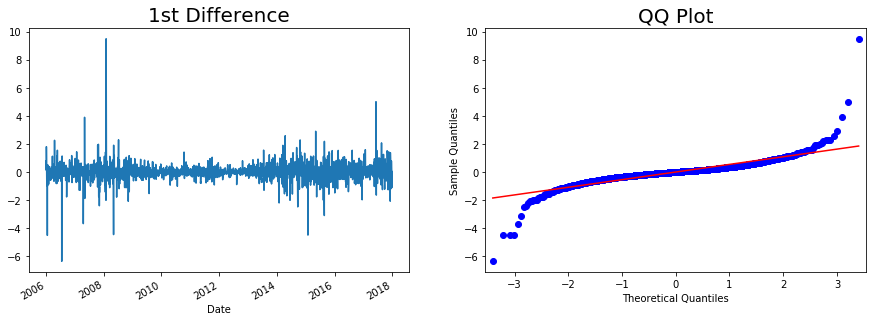

In [8]:
# Thử 1st difference để de-trend
fig1, ax1 = plt.subplots(1,2, figsize=(15,5))

diff_1 = df['Mean'].diff(1).plot(ax=ax1[0])
ax1[0].set_title('1st Difference', fontsize=20)

diff_1_qq = sm.qqplot(df['Mean'].diff(1)[1:], line='s', ax=ax1[1])
ax1[1].set_title('QQ Plot', fontsize=20)

In [9]:
# Chọn model
model = sm.tsa.ARIMA(df['Mean'], order=(2,1,1))

# Fit
fit = model.fit()

In [10]:
table = fit.summary()
table.tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0098,0.010,0.982,0.326,-0.010,0.029
ar.L1.D.Mean,0.8692,0.150,5.778,0.000,0.574,1.164
ar.L2.D.Mean,-0.1595,0.023,-6.874,0.000,-0.205,-0.114
ma.L1.D.Mean,-0.7032,0.152,-4.640,0.000,-1.000,-0.406


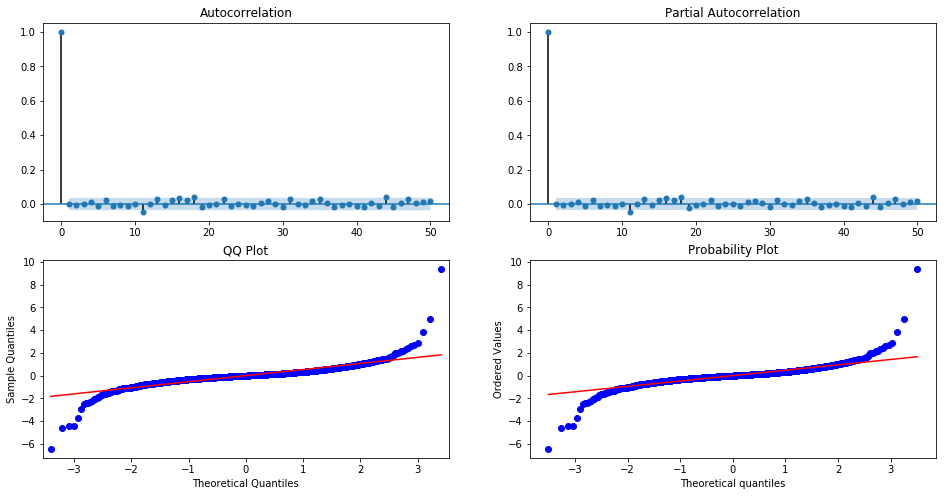

In [11]:
plot_tsa(fit.resid, 50)

Text(0.5, 1.0, 'Forecast, steps 30 days')

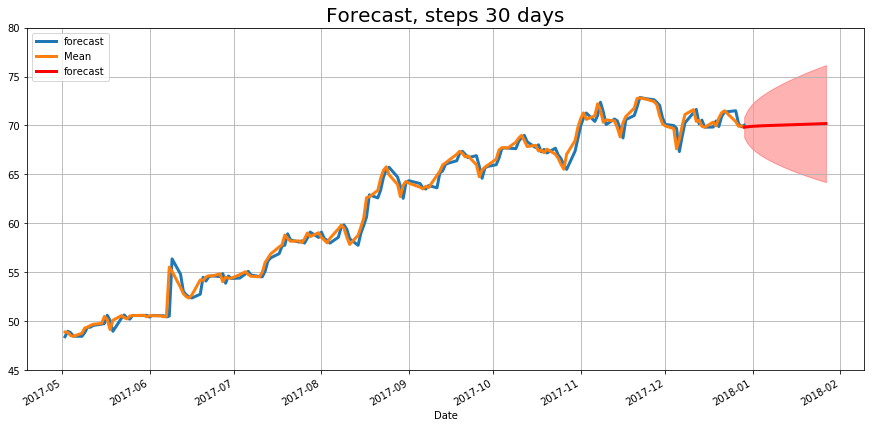

In [12]:
plt.rcParams['lines.linewidth'] = 3
steps = 30

forecast = fit.forecast(steps=steps)

ind = pd.date_range(df['Mean'].index[-1], periods=steps )
df_for = pd.DataFrame(forecast[0], index=ind, columns=['forecast'])
df_upper = pd.DataFrame(forecast[2][:,1], index=ind, columns=['upper_95%'])
df_lower = pd.DataFrame(forecast[2][:,0], index=ind, columns=['lower_95%'])
df_cc = pd.concat([df_upper, df_lower], axis=1)

plt.figure(figsize=(15,7))
ax = plt.gca()

fit.plot_predict(2850,ax=ax)

df_for.plot(ax=ax, color='red')
plt.fill_between(df_cc.index, df_cc['lower_95%'], df_cc['upper_95%'], color='r', alpha=.3)

plt.legend(loc='upper left')
plt.grid(True); plt.ylim(45, 80); plt.title('Forecast, steps 30 days', fontsize=20)

In [13]:
print('MAE: {:.2f}'.format(abs(fit.resid).mean()))

MAE: 0.32


#### Thử test lại

In [14]:
def chon_mo_hinh(df):
    best_iac = np.inf
    best_order = None
    best_model = None
    for p in range(3):
        for d in range(2):
            for q in range(2):
                try:
                    model_ = sm.tsa.ARIMA(df, order=(p, d, q))
                    fit = model_.fit()
                    model_aic = fit.aic
                    if model_aic < best_iac:
                        best_iac = model_aic
                        best_order = (p, d, q)
                        best_model = fit
                except:
                    continue
    print('AIC: {}, best order: {}'.format(best_iac, best_order))
    return best_model, best_model, best_order

In [15]:
chon_mo_hinh(df[['Mean']])

AIC: 4804.639396902378, best order: (2, 1, 1)


(<statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x27f3c295278>,
 (2, 1, 1))

#### OK, các thông số ổn

# Thử forecast với mô hình FBprophet của Facebook

In [14]:
from fbprophet import Prophet

In [23]:
# preprocessing data
df_ = df[['Mean']].reset_index()
df_.columns = ['ds','y']
df_.head()

,ds,y
0,2006-01-03,39.240
1,2006-01-04,40.995
2,2006-01-05,40.890
3,2006-01-06,42.840
4,2006-01-09,42.960


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


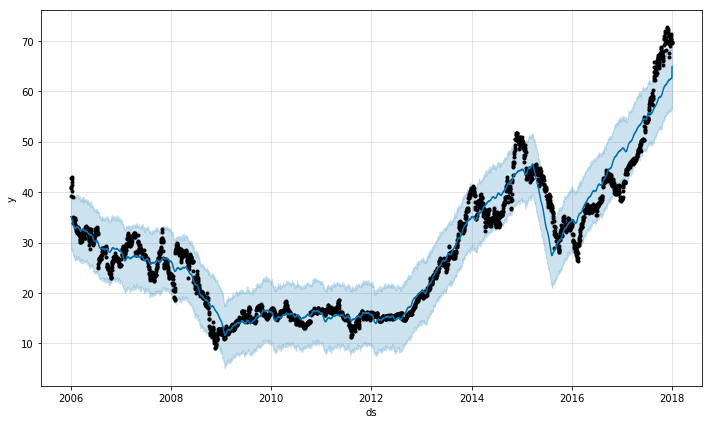

In [45]:
# Model
model = Prophet(interval_width=0.95)
model.fit(df_)

# Forecast
d_f = model.make_future_dataframe(1, freq='D')
pred = model.predict(d_f)

# Plot
plt.rcParams['figure.figsize'] = 15,6
pl_ = model.plot(pred)

In [88]:
df_mae = pd.concat([df_, pred[['yhat']]], axis=1)[0:-1]
df_mae['mae'] = df_mae['y'] - df_mae['yhat']
print('MAE: {}, MAPE : {}'.format(abs(df_mae['mae']).mean(), (abs(df_mae['mae'])/df_mae['y']).mean()))

MAE: 2.2500914796538978, MAPE : 0.07794753273009135


In [72]:
def plot_tsa(df, lags):
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    sm.graphics.tsa.plot_acf(df, lags=lags, ax = ax[0,0])
    sm.graphics.tsa.plot_pacf(df, lags= lags, ax = ax[0,1])
    
    sm.qqplot(df, line='s', ax=ax[1,0])
    ax[1,0].set_title('QQ Plot')
    probplot.probplot(df, plot=ax[1,1])
    
    #plt.tight_layout()
    return

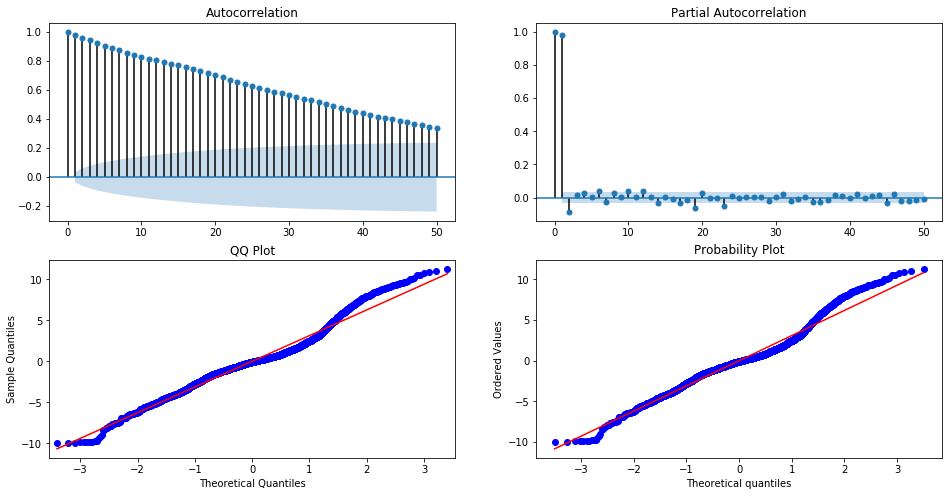

In [90]:
plot_tsa(df_mae['mae'], 50)

### So với mô hình ARIMA thì fbProphet không tốt hơn